***
### Table of Contents
1. [Import data](#import) data
2. [Customising your embedding models](#defn) 
    * optimizers
    * callbacks
    * etc.
3. [Setting up](#compile) your embedding models
4. [Training](#fit) your model
***

This notebook shows you ways through which you can have more control over your training process

In [1]:
%load_ext autoreload
%autoreload 2
from causalnet import metrics, data_processing, model, train
import numpy as np
import pandas as pd
import json
import shutil
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
import os
from pathlib import Path
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, TerminateOnNaN
import os
os.chdir("..")
np.random.seed(42)

<a id="import"></a>
### Importing data

First, we define a few things, like which variables we're using as categorical, continuous, response, treatment, and weight in our dataset. We'll also need to point this workbook to the toy dataset used to demo the process.

In [2]:

import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml

#Function to fetch the data
def load_mtpl2(n_samples=100000):
    """Fetch the French Motor Third-Party Liability Claims dataset.

    Parameters
    ----------
    n_samples: int, default=100000
      number of samples to select (for faster run time). Full dataset has
      678013 samples.
    """
    # freMTPL2freq dataset from https://www.openml.org/d/41214
    df_freq = fetch_openml(data_id=41214, as_frame=True)["data"]
    df_freq["IDpol"] = df_freq["IDpol"].astype(int)
    df_freq.set_index("IDpol", inplace=True)

    # freMTPL2sev dataset from https://www.openml.org/d/41215
    df_sev = fetch_openml(data_id=41215, as_frame=True)["data"]

    # sum ClaimAmount over identical IDs
    df_sev = df_sev.groupby("IDpol").sum()

    df = df_freq.join(df_sev, how="left")
    df["ClaimAmount"].fillna(0, inplace=True)

    # unquote string fields
    for column_name in df.columns[df.dtypes.values == object]:
        df[column_name] = df[column_name].str.strip("'")
    return df.iloc[:n_samples]



df = load_mtpl2(n_samples=300000)
df

#Categorical Variable definition
categorical_variables = df.select_dtypes(include=['object','category']).columns.tolist()

#Continuous variable definition
continuous_variables = df.select_dtypes(include=['number']).columns.tolist()
##Removing our target variable
continuous_variables.remove('ClaimAmount')

#Treatment variable definition
treatment=["treatment"]
df["treatment"] = np.random.choice([0, 1], size=(len(df),), p=[2/3, 1/3])

#Weight variable definition
weight=["weight"]
df["weight"] = np.random.uniform(low=0.9, high=1.1, size=len(df))

#Target variable definition
target = ['ClaimAmount']


#Finding optimal max value for our target variable, since some values can get very large
percent_clip = 0.7
npTarget = df.ClaimAmount.values
filtered = npTarget[npTarget>0.1]
target_clip_val = np.quantile(filtered,percent_clip)
total, gt_percentile = len(npTarget), len(npTarget[npTarget>target_clip_val])
print("If we clip `target` values above the {}th percentile, we'd alter {:.2}% of our data.\nThis is a clip value of {:.4}".format(int(percent_clip*100),100*gt_percentile/total, target_clip_val))


If we clip `target` values above the 70th percentile, we'd alter 1.3% of our data.
This is a clip value of 1.172e+03


In [3]:
## Create our custom causalNet data object

causalNet = data_processing.preprocessing(data = df, 
                      categorical_variables = categorical_variables, 
                      continuous_variables= continuous_variables, 
                      target_variable = target, 
                      weight_variable = weight,  
                      treatment_variable = treatment, 
                      scale_y = False,
                      weight_target = False, #Default. Let's not weight our response.
                      train_split = .8, #Default
                      random_state = 11,
                      y_clip=target_clip_val) #Pass the clipping threshold we determined already 

Setting max value of target variable at 1172.00


To have a more customised embedding model process, you can split the custom causalNet data object into your training & testing data & that can be passed directly for training/

In [4]:
## Unpack the dragon_data

x      = causalNet.x_preprocess 
y      = causalNet.target_preprocess
weight_col = causalNet.weight_preprocess
training_index = causalNet.training_index
testing_index  = causalNet.test_index   

x_train = {}
x_test= {}
for item in causalNet.x_preprocess:
    x_train[item] = causalNet.x_preprocess[item][training_index]
    x_test[item] = causalNet.x_preprocess[item][testing_index]
    
weight_train, weight_test = weight_col[training_index], weight_col[testing_index]

y_train, y_test = y[training_index], y[testing_index]

<a id="defn"></a>
### Defining custom model paramters:

With this package you can have more direct control over the following:
* callbacks - Used to instruct your model trainer to perform variety of tasks at the end of every epoch like plotting customs results in real time, change learning rate as the model loss saturates, stop training when the model results NaN results, etc.
* activations - Changing the activation function. To learn more : [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)


In [5]:
## Define our custom parameters
checkpoint_path = 'embed_checkpoint'
tf.random.set_seed(101)
optimizer = Adam(learning_rate=1e-6, 
                 beta_1=.9, 
                 beta_2=.999, 
                 epsilon=1e-3,
                 amsgrad=False)

callbacks = [
    train.TrainPerformanceViz(),
    TerminateOnNaN(),
    EarlyStopping(monitor='tweedie_loss', mode='min', patience=5, min_delta=0, restore_best_weights = True),
    ReduceLROnPlateau(monitor='tweedie_loss', mode='min', factor=0.5, patience=2, 
                     min_delta=1e-15, cooldown=5, min_lr=1e-15),
    ModelCheckpoint(
        filepath='embed_checkpoints/model.{epoch:02d}-{loss:.2f}', monitor='tweedie_loss', mode='min', verbose=0, save_best_only=False,
        save_weights_only=False, save_freq='epoch')
    
            ]

<a id="compile"></a>:
### Compiling embedding model
The more complex section of code below will check the defined checkpoint location for existing checkpoints:
* If checkpoints exist, resume training. 
* Otherwise, define a new embeddig model. 

This section can be simplified to the following if desired:

```python
inputs, outputs = models.embedding_network(dragon_data, activation='custom_activation')
embed_model = Model(inputs, outputs)
```

In [6]:
import glob
try:
    print("Checking for saved checkpoints....")
    list_of_folders = glob.glob(str(checkpoint_path)+'/*')
    total_epochs = len(list_of_folders)
    latest_file = max(list_of_folders, key=os.path.getctime)
    print("Loading checkpoint from " + latest_file)
    embed_model = load_model(latest_file)
except:
    print("No checkpoint found. Creating embedding model from scratch.")
    inputs, outputs = model.emdedding_net_skeleton(causalNet, activation='sigmoid')
    total_epochs = 0
    embed_model = Model(inputs, outputs)

Checking for saved checkpoints....
Loading checkpoint from embed_checkpoint\model.05-25.95
No checkpoint found. Creating embedding model from scratch.

 -----------------------------
 Embedding skeleton created!!!


In [7]:
embed_model.compile(optimizer=optimizer,
              loss='tweedie_loss',
              metrics=['mean_squared_logarithmic_error','tweedie_loss'],
              loss_weights = weight_train)

<a id="fit"></a>
### Training the embedding model


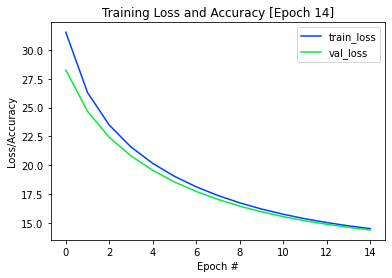

INFO:tensorflow:Assets written to: embed_checkpoints\model.15-14.51\assets


INFO:tensorflow:Assets written to: embed_checkpoints\model.15-14.51\assets


In [8]:
embed_model.fit(x = x_train, 
                y = y_train,
                epochs = 15-total_epochs,
                callbacks = callbacks,
                batch_size = 64*3,
                validation_split = .3
                 )

In [9]:
shutil.rmtree(checkpoint_path)